In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys

from utils.data_utils import SAMPLING_FREQUENCY, load_data
from custom.models import get_multi_output_model

import tensorflow as tf
from tensorflow import keras

## Prerequisites

Specify the directory where the data is stored.

In [2]:
ROOT_DIR = '/mnt/neurogeriatrics_data/MobiliseD_TVS/rawdata' if sys.platform == 'linux' else 'Z:\\MobiliseD_TVS\\rawdata'

Get train and test data, where the proportion of test data is 20% of the subjects.

In [3]:
train_data, test_data = load_data(path=ROOT_DIR, sequence_length=10., overlap=0., test_size=0.2)

Split the train data into features and labels. For the labels, differentiate between labels for gait sequences and gait events.

In [4]:
train_features, train_labels = train_data[:,:,:-2], train_data[:,:,-2:]
gait_labels = np.expand_dims(train_labels[:,:,0], axis=-1)
event_labels = np.expand_dims(train_labels[:,:,1], axis=-1)
event_labels = keras.utils.to_categorical(event_labels)
print(f'Shape of train features: {train_features.shape}')
print(f'Shape of gait labels: {gait_labels.shape}')
print(f'Shape of event labels: {event_labels.shape}')

Shape of train features: (16592, 640, 12)
Shape of gait labels: (16592, 640, 1)
Shape of event labels: (16592, 640, 5)


Get a multi-output model that simultaneously classifies gait sequences as well as specific gait events.

2022-06-21 14:08:05.445133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 14:08:05.482742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 14:08:05.482875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 14:08:05.483235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 12)]   0           []                               
                                                                                                  
 tcn (TCN)                      (None, None, 64)     167360      ['inputs[0][0]']                 
                                                                                                  
 gait_sequences (Dense)         (None, None, 1)      65          ['tcn[0][0]']                    
                                                                                                  
 concat (Concatenate)           (None, None, 65)     0           ['tcn[0][0]',                    
                                                                  'gait_sequences[0][0]'] 

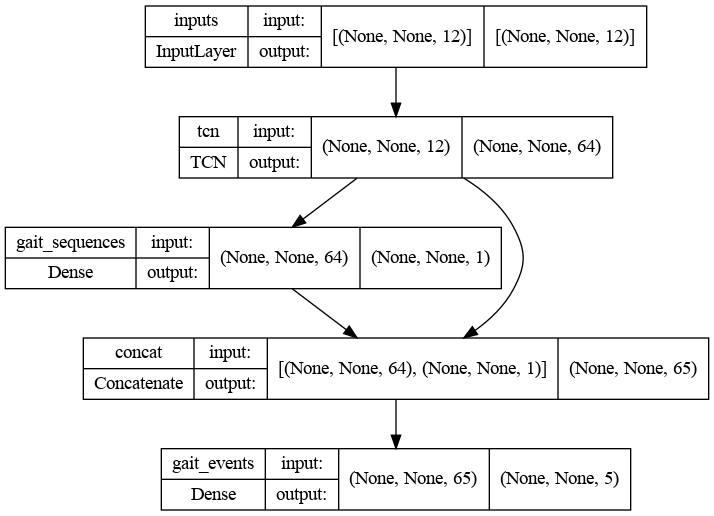

In [5]:
multi_output_model = get_multi_output_model(nb_channels=train_features.shape[-1], nb_classes=event_labels.shape[-1])
multi_output_model.summary()
keras.utils.plot_model(multi_output_model, show_shapes=True)

Define callbacks to reduce the chance of overfitting.

In [8]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience = 5,         # number of epochs in a row in which there is no improvement
        monitor = 'val_loss', # which performance metric to use
        mode = 'min'          # minimize or maximize the performance metric
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = './training/runs',
        monitor = 'val_loss',
        save_best_only = True,
        save_weight_only = False,
        mode = 'min'
    )
]

In [9]:
multi_output_history = multi_output_model.fit(
    x = train_features,
    y = {'gait_sequences': gait_labels,
         'gait_events': event_labels},
    batch_size = 16,
    epochs = 50,
    shuffle = True,
    validation_split = 0.3,
    callbacks = callbacks
)

Epoch 1/50
726/726 [==============================] - ETA: 0s - loss: 0.0035 - gait_sequences_loss: 0.0016 - gait_events_loss: 0.0019 - gait_sequences_binary_accuracy: 0.9818 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9982 - gait_events_categorical_accuracy: 0.9956

2022-06-21 14:58:02.976487: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./training/runs/assets


INFO:tensorflow:Assets written to: ./training/runs/assets


726/726 [==============================] - 19s 24ms/step - loss: 0.0035 - gait_sequences_loss: 0.0016 - gait_events_loss: 0.0019 - gait_sequences_binary_accuracy: 0.9818 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9982 - gait_events_categorical_accuracy: 0.9956 - val_loss: 0.0025 - val_gait_sequences_loss: 0.0016 - val_gait_events_loss: 8.4891e-04 - val_gait_sequences_binary_accuracy: 0.9878 - val_gait_sequences_categorical_accuracy: 1.0000 - val_gait_events_binary_accuracy: 0.9994 - val_gait_events_categorical_accuracy: 0.9985
Epoch 2/50
726/726 [==============================] - 12s 17ms/step - loss: 0.0034 - gait_sequences_loss: 0.0016 - gait_events_loss: 0.0019 - gait_sequences_binary_accuracy: 0.9822 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9983 - gait_events_categorical_accuracy: 0.9956 - val_loss: 0.0026 - val_gait_sequences_loss: 0.0016 - val_gait_events_loss: 9.3847e-04 - val_gait_sequences_binary_accurac

In [10]:
multi_output_history.history.keys()

dict_keys(['loss', 'gait_sequences_loss', 'gait_events_loss', 'gait_sequences_binary_accuracy', 'gait_sequences_categorical_accuracy', 'gait_events_binary_accuracy', 'gait_events_categorical_accuracy', 'val_loss', 'val_gait_sequences_loss', 'val_gait_events_loss', 'val_gait_sequences_binary_accuracy', 'val_gait_sequences_categorical_accuracy', 'val_gait_events_binary_accuracy', 'val_gait_events_categorical_accuracy'])

In [11]:
predictions = multi_output_model.predict(x=train_features)

In [15]:
for i in range(len(predictions)):
    print(type(predictions[i]))
    print(predictions[i].shape)

<class 'numpy.ndarray'>
(16592, 640, 1)
<class 'numpy.ndarray'>
(16592, 640, 5)


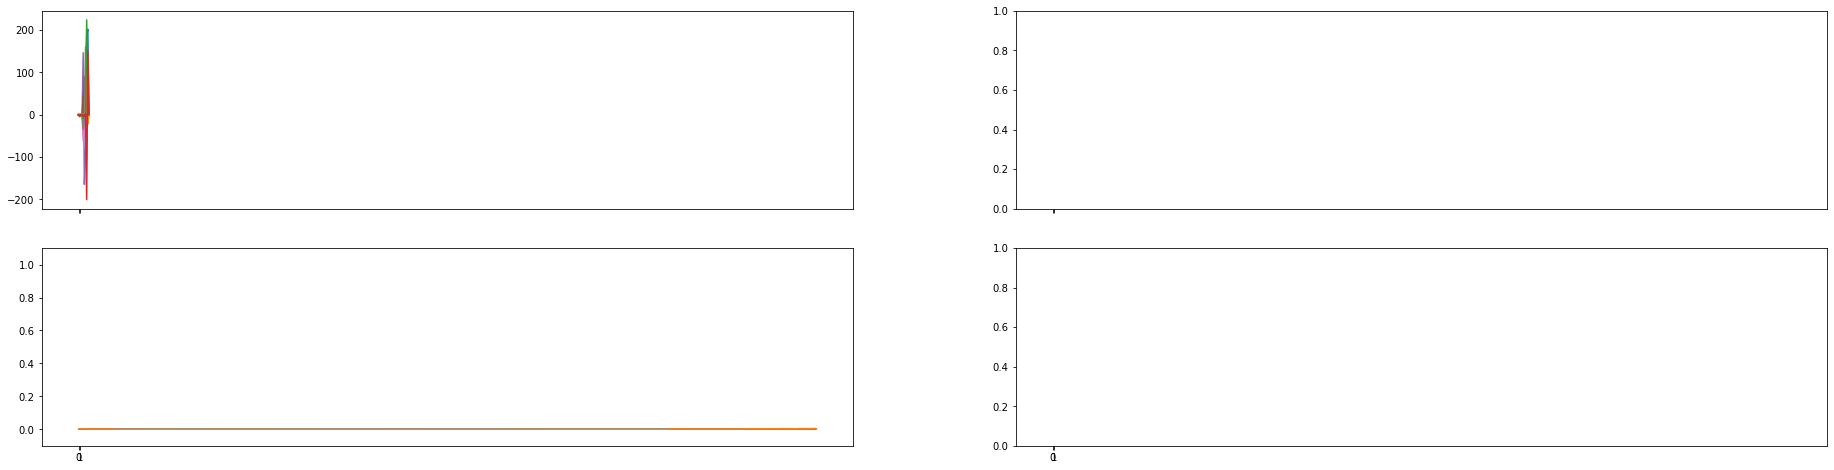

In [46]:
ix_random = np.random.choice(predictions[0].shape[0], 1, replace=False)[0]

fig, axs = plt.subplots(2, 2, figsize=(32, 8), sharex=True)
axs[0][0].plot(train_features[ix_random:ix_random+10][:,4])
axs[0][0].plot(train_features[ix_random:ix_random+10][:,10])
axs[1][0].plot(gait_labels[ix_random][:,0])
axs[1][0].plot(predictions[0][ix_random][:,0])
axs[1][0].set_ylim([-0.1, 1.1])
axs[1][0].set_xticks([0, 1])
plt.show()